# Classical Communication and RSA Encryption

Classical communication involves transmitting information using classical bits (0 or 1). In the context of cryptography, RSA encryption relies on the difficulty of factoring large composite numbers into their prime factors. The security of RSA is based on the assumption that factoring is computationally infeasible for classical computers, even for large numbers with hundreds of digits.

In [20]:
import numpy as np
from fractions import Fraction

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

# Shor's Algorithm

Shor's algorithm is a quantum algorithm that can factor large numbers efficiently. By leveraging quantum superposition and entanglement, it finds the prime factors of a composite number in polynomial time, unlike classical algorithms which take exponential time. This capability poses a significant threat to RSA encryption, as it could allow an attacker with a sufficiently powerful quantum computer to break RSA-encrypted messages.

The implementation below demonstrates Shor's factoring algorithm using Qiskit.

In [4]:
simulator = AerSimulator()
sampler = SamplerV2(mode=simulator)
pm = generate_preset_pass_manager(optimization_level=3, backend=simulator)

In [5]:
def to_int(bin_value):
    num = 0
    length = len(bin_value)
    for i in range(length):
        num += int(bin_value[length-1-i])*(2**i)

    return num

def R_k(k):
    mat = np.array([
        [1, 0],
        [0, np.exp(-(2*np.pi*1j)/(2**k))]
    ])
    return mat

def precompute_powers(x, N, t):
    powers = []

    powers.append(x%N)

    for _ in range(t-1):
        last = powers[-1]
        powers.append((last**2)%N)

    return powers

def mod_Gate(a, N, n):
    dim = 2**n
    U = np.zeros((dim, dim))
    for y in range(dim):
        if y < N:
            target = (a * y) % N
            U[target, y] = 1
        else:
            U[y, y] = 1
    return UnitaryGate(U, label=f"{a}·y mod {N}")

def U_k(qc, x, N, n, t):
    powers = precompute_powers(x, N, t)
    
    for i in range(t):
        gate = mod_Gate(powers[i], N, n)
        controlled_gate = gate.control(1)

        ls = [t-i-1]
        for j in range(n):
            ls.append(t+j)

        qc.append(controlled_gate, ls)

In [6]:
def order(x, N):
    L = int(np.ceil(np.log2(N)))
    epsilon = 0.1
    t = int(2*L + 1 + np.ceil(np.log2(2 + (1/(2*epsilon)))))

    qr = QuantumRegister(t + L, 'q')
    cr = ClassicalRegister(t, 'c')
    qc = QuantumCircuit(qr, cr)
    qc.x(t + L - 1)

    for i in range(t):
        qc.h(i)

    U_k(qc, x, N, L, t)

    # Inverse QFT
    for i in range(t-1):
        qc.h(i)
        for j in range(i+1, t):
            gate = UnitaryGate(R_k(j - i + 1), label=f"R_{j - i + 1}")
            controlled_gate = gate.control(1)
            qc.append(controlled_gate, [i, j])
    qc.h(t - 1)

    qc.barrier()
    qc.measure(range(t), range(t))

    tqc = pm.run(qc)
    result = sampler.run([tqc], shots=1024).result()
    counts = result[0].data.c.get_counts()

    # Convert to s / 2^t values
    total = sum(counts.values())
    probabilities = {int(k, 2) / (2 ** t): v / total for k, v in counts.items()}
    sorted_probs = sorted(probabilities.items(), key=lambda x: -x[1])

    theta = sorted_probs[0][0]
    frac = Fraction(theta).limit_denominator(N)
    r_guess = frac.denominator

    if pow(x, r_guess, N) == 1:
        return r_guess

    elif theta!=0:
        x_new = pow(x, r_guess, N)
        r_2 = order(x_new, N)
        return r_2*r_guess

    else:
        return 0

In [7]:
def root_find(N):
    for b in range(2, int(np.ceil(np.log2(N)))+1):
        a = N**(1/b)
        if a>=1 and int(a)==a:
            return a
    
    return None

def gcd(a, b):
    while b != 0:
        a, b = b, a % b
    return a

def factoring_algo(N):
    if N % 2 == 0:
        return [2]
    
    a = root_find(N)

    if a is not None:
        return [a]
    
    x = np.random.randint(2, N)
    gc = gcd(x, N)

    if (gc>1):
        return [gc]
    
    else:
        r = order(x, N)
        res = []

        if (r!=0) and (r%2==0) and (pow(x,r//2,N)!=(N-1)):
            gc1 = gcd(((x**(r/2))-1), N)
            gc2 = gcd(((x**(r/2))+1), N)

            if (gc1!=1) and (gc1!=N):
                res.append(int(gc1))

            if (gc2!=1) and (gc2!=N):
                res.append(int(gc2))

            return res
        
        else:
            return []

def factor(N):
    res = []
    while (N>1):
        factor = factoring_algo(int(N))
        
        if (factor == []):
            if (N>1):
                res.append(int(N))
            break

        for i in factor:
            res.append(i)

            while N%i==0:
                N=N/i
    
    return res

In [8]:
# factor(165)

# Introduction to Quantum Information

Quantum information science extends classical information theory to the quantum realm. While classical bits are 0 or 1, quantum bits (qubits) can be in superposition, representing both 0 and 1 simultaneously. This property, along with entanglement, enables quantum protocols like Superdense Coding and Teleportation that surpass classical limits.

A qubit can be represented as |ψ⟩ = α|0⟩ + β|1⟩, where α and β are complex amplitudes with |α|² + |β|² = 1. Measurement collapses the state to 0 or 1 with probabilities |α|² and |β|².

# Quantum Gates and Circuits (Recap)

Quantum gates manipulate qubits. Key gates include:
- Hadamard (H): Creates superposition, H|0⟩ = (|0⟩ + |1⟩)/√2
- Pauli X: Flips qubit, X|0⟩ = |1⟩
- Pauli Z: Phase flip, Z|0⟩ = |0⟩, Z|1⟩ = -|1⟩
- CNOT: Entangles qubits, flips target if control is 1

Circuits combine gates to implement algorithms.

# Entanglement and Bell States (Recap)

Entanglement links qubits so the state of one instantly affects the other, regardless of distance. Bell states are maximally entangled:
- |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
- |Φ⁻⟩ = (|00⟩ - |11⟩)/√2
- |Ψ⁺⟩ = (|01⟩ + |10⟩)/√2
- |Ψ⁻⟩ = (|01⟩ - |10⟩)/√2

Entanglement is key to quantum communication protocols.

# SuperDense Coding

Superdense Coding allows sending 2 classical bits using 1 qubit, leveraging shared entanglement. Alice and Bob share a Bell pair. Alice encodes 2 bits on her qubit and sends it to Bob, who decodes the message.

## The Process <a id='process'></a>

![image1](./Communication/superdense.jpg)

### 2.1 Step 1 <a id='step1'></a>
The process starts with a third party, who we'll call Charlie. Two qubits are prepared by Charlie in an entangled state. He initially starts the 2 qubits in the basis state $|0\rangle$. He applies Hadamard gate ($H$) to the first qubit to create superposition. He then applies CNOT gate ($CX$) using the first qubit as a control and the second as the target. This is the entangled state (Bell pair) we mentioned earlier. 

#### Outcome States

We start in the state:

$$|00\rangle = |0\rangle_A\otimes |0\rangle_B$$

where the qubit to be sent to Alice is labeled with $A$ and the qubit to be sent to Bob is labeled $B$. Charlie first applies a Hadamard gate to the first qubit, which creates superposition and we get the state:


$$|+0\rangle  =  \tfrac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$$



Then Charlie applies the CNOT gate. The CNOT gate entangles both qubits, i.e. it flips the target if the control is $|1\rangle$. Note that the control qubit is our leftmost qubit.



$$\text{CNOT} \tfrac{1}{\sqrt{2}}(|00\rangle + |10\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$



### Step 2 <a id='step2'></a>

Charlie sends the first qubit to Alice and the second qubit to Bob. The goal of the protocol is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send:


#### Encoding Rules for Superdense Coding (Alice protocol):
<table>
    <tr>
        <th>Intended Message</th>
        <th>Applied Gate</th>
        <th>Resulting State ($\cdot\tfrac{1}{\sqrt{2}}$)</th>
    </tr>
    <tr>
        <td>00</td>
        <td>$I$</td>
        <td>$|00\rangle + |11\rangle$</td>
    </tr>
    <tr>
        <td>01</td>
        <td>$X$</td>
        <td>$|10\rangle + |01\rangle$</td>
    </tr>
    <tr>
        <td>10</td>
        <td>$Z$</td>
        <td>$|00\rangle - |11\rangle$</td>
    </tr>
    <tr>
        <td>11</td>
        <td>$ZX$</td>
        <td>$-|10\rangle + |01\rangle$</td>
    </tr>
</table>

Thus if she wants to send a `00`, she does nothing to her qubit (apply the identity ($I$) gate). If she wants to send a `01`, then she applies the $X$ gate. Depending on what she wants to send, she applies the appropriate gate, then sends her qubit to Bob for the final step in the process.


### Step 3 <a id='step3'></a>

Bob receives Alice's qubit (leftmost qubit) and uses his qubit to decode Alice's message. Notice that he does not need to have knowledge of the state in order to decode it — he simply uses the restoration operation.

Bob applies a CNOT gate using the leftmost qubit as control and the rightmost as target. Then he applies a Hadamard gate and finally performs a measurement on both qubits to extract Alice's message.

<table>
    <tr>
        <th>Bob Receives ($\cdot\tfrac{1}{\sqrt{2}}$)</th>
        <th>After CNOT-gate ($\cdot\tfrac{1}{\sqrt{2}}$)</th>
        <th>After H-gate</th>
    </tr>
    <tr>
        <td>$|00\rangle + |11\rangle$</td>
        <td>$|00\rangle + |10\rangle$</td>
        <td>$|00\rangle$</td>
    </tr>
    <tr>
        <td>$|10\rangle + |01\rangle$</td>
        <td>$|11\rangle + |01\rangle$</td>
        <td>$|01\rangle$</td>
    </tr>
    <tr>
        <td>$|00\rangle - |11\rangle$</td>
        <td>$|00\rangle - |10\rangle$</td>
        <td>$|10\rangle$</td>
    </tr>
    <tr>
        <td>$-|10\rangle + |01\rangle$</td>
        <td>$-|11\rangle + |01\rangle$</td>
        <td>$|11\rangle$</td>
    </tr>
</table>

## Simulating the Superdense Coding Protocol <a id='simulating'></a>

We saw that to create an entangled pair, we needed to do a H-gate followed by a CNOT. Let's create a function that takes a `QuantumCircuit` and entangles the qubits with indices `a` and `b`:

In [9]:
def create_bell_pair():
    """
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """
    qc = QuantumCircuit(2)
    qc.h(1)
    qc.cx(1, 0)
    return qc

Next we need to encode our message. We saw that there were four possible messages we could send: `00`, `10`, `01` or `11`. Let's create a function that takes this message and applies the appropriate gates for us:

In [10]:
def encode_message(qc, qubit, msg):
    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)
    return qc

Finally, we need to decode our message, we saw we could do this using a CNOT followed by a H-gate. Let's create a function that does this for us too:

In [11]:
def decode_message(qc):
    qc.cx(1, 0)
    qc.h(1)
    return qc

Finally, we can put this together to complete our protocol.

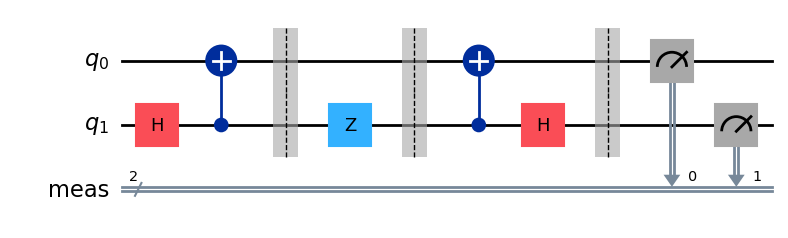

In [12]:
# Charlie creates the entangled pair between Alice and Bob
qc = create_bell_pair()

# We'll add a barrier for visual separation
qc.barrier()

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 1. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = '10'
qc = encode_message(qc, 1, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After receiving qubit 0, Bob applies the recovery protocol:
qc = decode_message(qc)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw('mpl')

### 3.1 Visualizing Our Measurements <a id='visualising'></a>

{'10': 1024}


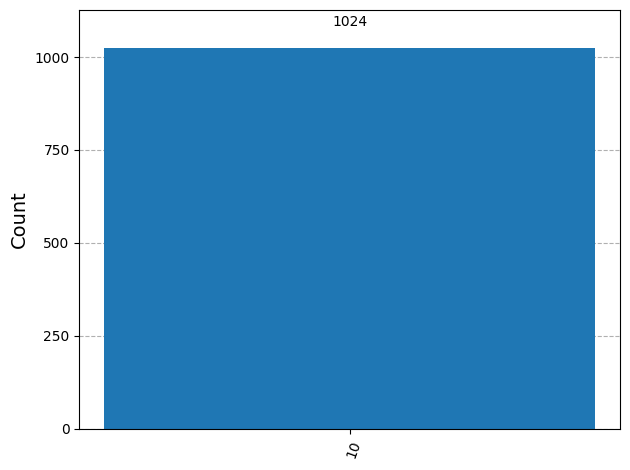

In [13]:
aer_sim = AerSimulator()
result = aer_sim.run(qc).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

Our simulator simulates a perfect quantum computer. We can see that, without errors, we get a 100% chance of measuring the correct message.

# Quantum Teleportation

Quantum Teleportation transfers a quantum state from Alice to Bob using a shared entangled pair and 2 classical bits. Alice has an unknown state |ψ⟩, they share a Bell pair. Alice performs a Bell measurement on her qubits, sends the classical bits to Bob, who applies conditional gates to reconstruct |ψ⟩.

## The Process

1. Alice prepares |ψ⟩ on her qubit 0.
2. Create Bell pair between Alice's qubit 1 and Bob's qubit 2.
3. Alice applies CNOT(0,1), H(0), measures qubits 0 and 1, sends bits to Bob.
4. Bob applies X on qubit 2 if bit from qubit 1 is 1, Z if bit from qubit 0 is 1.

Full Teleportation Circuit


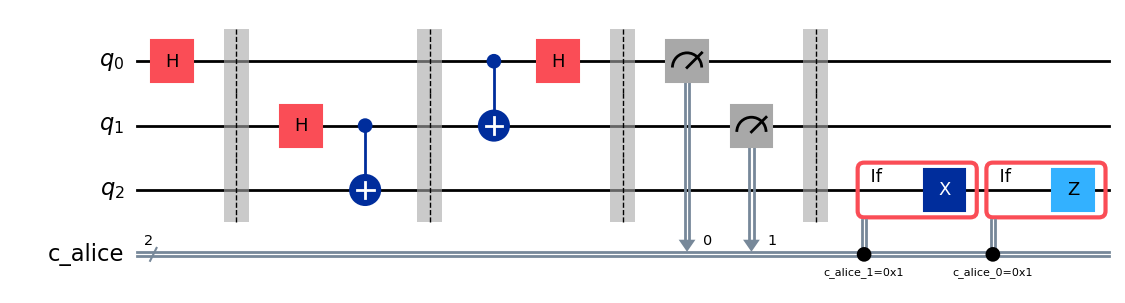

In [14]:
# Define quantum and classical registers
qr_tele = QuantumRegister(3, name='q')
cr_alice_tele = ClassicalRegister(2, name='c_alice') # For Alice's measurements

# For verification with statevector, we don't measure Bob's final qubit in this circuit.
# If we were to run on hardware and verify by counts, we'd add a classical bit for Bob.
teleport_qc = QuantumCircuit(qr_tele, cr_alice_tele, name='Teleportation')

# Prepare Alice's message state |ψ> = |+> on q0
teleport_qc.h(qr_tele[0])
teleport_qc.barrier()

# Step 1: Create Bell pair between q1 (Alice) and q2 (Bob)
teleport_qc.h(qr_tele[1])
teleport_qc.cx(qr_tele[1], qr_tele[2])

teleport_qc.barrier()

# Step 2: Alice's Bell Measurement (gates part))
teleport_qc.cx(qr_tele[0], qr_tele[1])
teleport_qc.h(qr_tele[0])

teleport_qc.barrier()

# Alice measures her qubits q0 and q1
teleport_qc.measure(qr_tele[0], cr_alice_tele[0]) # q0 -> c0
teleport_qc.measure(qr_tele[1], cr_alice_tele[1]) # q1 -> c1
teleport_qc.barrier()

# Step 3: Bob's Conditional Corrections on q2
with teleport_qc.if_test((cr_alice_tele[1],1)):
    teleport_qc.x(qr_tele[2])
with teleport_qc.if_test((cr_alice_tele[0],1)):
    teleport_qc.z(qr_tele[2])

print("Full Teleportation Circuit")
display(teleport_qc.draw('mpl'))

Using statevector simulator...
Running statevector simulation...
Simulation successful.
Statevector retrieved successfully.

Visualizing final qubit states (q2 should match initial q0 state |+>):


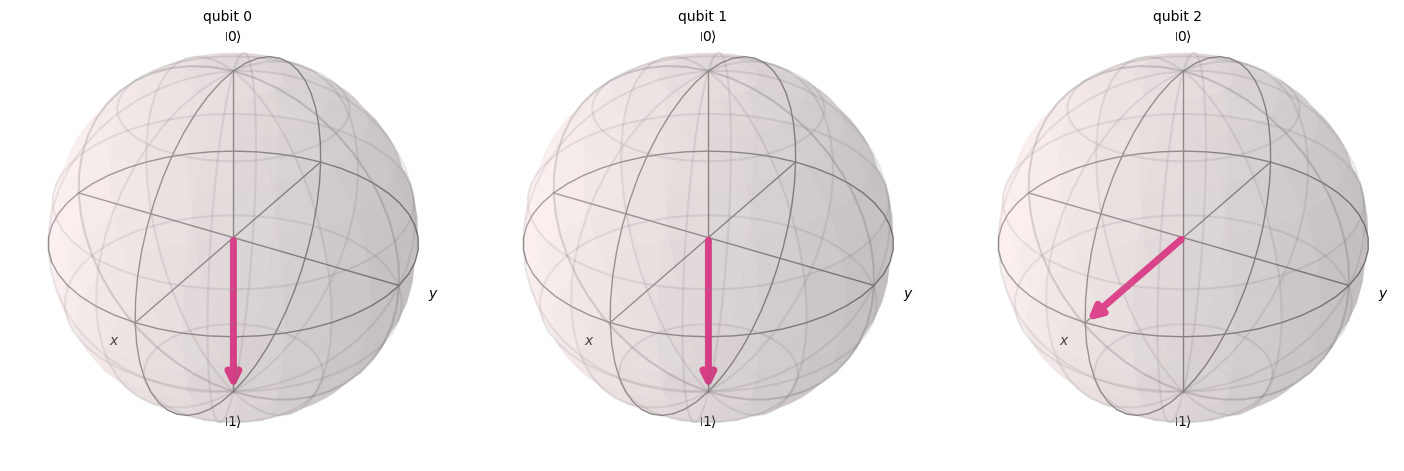

In [15]:
print("Using statevector simulator...")
sv_simulator = AerSimulator(method='statevector') # Explicitly set method for clarity
teleport_qc_sv = teleport_qc.copy() # Work with a copy for statevector simulation
teleport_qc_sv.save_statevector() # Save statevector at the end

print("Running statevector simulation...")
job_sv = sv_simulator.run(teleport_qc_sv) # shots=1 is default for statevector
result_sv = job_sv.result()

if result_sv.success:
    print("Simulation successful.")
    final_statevector = result_sv.get_statevector()
    print("Statevector retrieved successfully.")
    print("\nVisualizing final qubit states (q2 should match initial q0 state |+>):")
    # q0 was |+> (points along +X). After teleportation, q2 should be |+>.
    # q0 and q1 states are after Alice's measurement, so they'll be collapsed.
    
    display(qiskit.visualization.plot_bloch_multivector(final_statevector)) #TODO, use plot_bloch_multivector to plot final_state
        
else:
    print(f"Statevector simulation failed! Status: {result_sv.status}")

## Quantum Cryptographic Algorithms: BB84, BB91, and BB92

Quantum cryptography leverages the principles of quantum mechanics to achieve secure communication. Unlike classical cryptography, its security is based on the laws of physics rather than computational assumptions. Here are some foundational quantum cryptographic protocols:

### BB84 Protocol

- **Proposed by:** Charles Bennett and Gilles Brassard in 1984.
- **Purpose:** Quantum Key Distribution (QKD).
- **How it works:** 
    - Alice encodes random bits in randomly chosen bases (rectilinear or diagonal) and sends qubits to Bob.
    - Bob measures each qubit in a randomly chosen basis.
    - After transmission, Alice and Bob publicly compare bases (not measurement results) and keep only the bits where their bases matched.
    - The resulting shared key is secure against eavesdropping due to the no-cloning theorem and measurement disturbance.

### E91 Protocol

- **Proposed by:** Artur Ekert in 1991 (often referred to as E91).
- **Purpose:** Quantum Key Distribution using entanglement.
- **How it works:**
    - An entangled pair source sends one qubit to Alice and one to Bob.
    - Both choose random measurement bases and record results.
    - By comparing a subset of their results, they can detect eavesdropping via Bell’s inequality violations.
    - The remaining correlated results form a secure key.

### B92 Protocol

- **Proposed by:** Charles Bennett in 1992.
- **Purpose:** Simplified QKD protocol.
- **How it works:**
    - Alice encodes bits using only two non-orthogonal quantum states (instead of four as in BB84).
    - Bob randomly chooses one of two measurement bases.
    - Only certain measurement outcomes are kept, forming the key.
    - Security is still guaranteed by quantum mechanics, but the protocol is more resource-efficient.

In [16]:
import base64
from cryptography.fernet import Fernet
import hashlib

In [17]:
num_qubits = 64
rng = np.random.default_rng(seed=10)

alice_state = rng.integers(0, 2, size=num_qubits)
bob_basis = rng.integers(0, 2, size=num_qubits)

print(f"Alice's State:\t {np.array2string(alice_state, separator='')}")
print(f"Bob's Bases:\t {np.array2string(bob_basis, separator='')}")

Alice's State:	 [1100111011000101001101001111110110110001100110010110101100110000]
Bob's Bases:	 [1101001000000011110100000000011011001001111111110011010000111001]


In [18]:
def make_b92_circ(enc_state, meas_basis):
    '''
    A function that makes a B92 QKD protocol simulation circuit
    
    enc_state: array of 0s and 1s denoting the state to be encoded using the following scheme:
                0 -> |0>
                1 -> |+>
    
    meas_basis: array of 0s and 1s denoting the basis to be used for measurement
                0 -> Hadamard Basis
                1 -> Computational Basis
    
    Note that both enc_state and meas_basis are arrays of integers, so if you are using them in 
    if statements, compare them to integer values like 0 and 1 (without quotes).
    
    Since this is a function, you only have access to the variables enc_state and meas_basis.
    You may define other local variables. One such variable, num_qubits has been defined for you. 
    This is the number of qubits in the B92 simulation QuantumCircuit()
    '''
    num_qubits = len(enc_state)

    b92 = QuantumCircuit(num_qubits)

    # Sender prepares qubits
    # To encode the state in qubits
    for index in range(len(enc_state)):
        if enc_state[index] == 1:
            b92.h(index)  
    b92.barrier()  
    # Receiver measures the received qubits
    # To change basis for measurements. 
    for index in range(len(meas_basis)):
        if meas_basis[index] == 0:
            b92.h(index)

    # b92.barrier()    
    b92.measure_all()
    return b92

b92_circ = make_b92_circ(alice_state, bob_basis)

In [22]:
sampler = SamplerV2(mode=AerSimulator())
result = sampler.run([b92_circ]).result()
counts = result[0].data.meas.get_counts()
temp_key = list(counts.keys())[0][::-1]

print(f"Bob's results:\t{temp_key}")

Bob's results:	1100001000010001000000010000010000000000000110001010000010000010


In [23]:
def b92_sifting(enc_state, meas_basis, meas_result):
    sender_key = ''
    receiver_key = ''
    for i in range(len(enc_state)):
        if meas_result[i] == '1':  # conclusive outcome
            bit = str(int(enc_state[i]))
            sender_key += bit
            receiver_key += bit
    return sender_key, receiver_key

alice_key, bob_key = b92_sifting(alice_state, bob_basis, temp_key)

print(f"Alice's Key: \t{alice_key}")
print(f"Bob's Key: \t{bob_key}")

Alice's Key: 	1110101110100
Bob's Key: 	1110101110100


In [24]:
fernet_key = base64.urlsafe_b64encode(hashlib.sha256(bob_key.encode()).digest())
g = Fernet(fernet_key)

msg = "Quantum communication successful!"
encrypted = g.encrypt(msg.encode())
print("Encrypted message:", encrypted)
print("Decrypted message:", g.decrypt(encrypted).decode())


Encrypted message: b'gAAAAABo6hPBXFZ574RCTjU0QOqhEmDgVWq6f_C3gOOaJcdmdvfLvDbilwdYYJuSZnqAapJP3_PgzZaBcPFO7bR2hjOYfhZrdkis7XBuMqzJm5D6jjehiC18S5cXCFRe_jnH69-RqYjk'
Decrypted message: Quantum communication successful!


These protocols form the basis of modern quantum cryptography, enabling secure communication that is fundamentally protected against eavesdropping.